In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import re
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('dataset1m.csv', encoding_errors='ignore')
df.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    # text = re.sub(r"'s", " is", text)

    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", text)
    return text

In [6]:
df['clean_text'] = df['text of the tweet'].apply(clean_text)

In [8]:
df.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet,clean_text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it's not behaving at all i ...
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,kwesidei not the whole crew


In [35]:
int2label = {0: 'negative',
             2: 'neutral',
             4: 'positive'}

In [9]:
class Tokenizer:
    def __init__(self):
        self.word2count = {}
        self.tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
        
        
        self.word2id = {e: i for i, e in enumerate(self.tokens)}
        self.id2word = {i: e for i, e in enumerate(self.tokens)}
        
        self.word2count_thresh = {}
        
    def add_word(self, word):
        self.add_count(word)
        
        if word in self.word2id:
            return
        
        self.word2id[word] = len(self.word2id)
        self.id2word[self.word2id[word]] = word
        
    def add_count(self, word):
        if word in self.word2count:
            self.word2count[word] += 1
        else:
            self.word2count[word] = 1
            
    def drop_words_below_thresh(self, threshold=15):
        self.word2count_thresh = {k: v for k, v in self.word2count.items() if v > threshold}
        
            
tokenizer = Tokenizer()


In [42]:
X = df['clean_text'].values
Y = df['polarity of tweet'].values / 2
print(X)
Y

['is upset that he cannot update his facebook by texting it and might cry as a result  school today also blah!'
 'kenichan i dived many times for the ball managed to save 50%  the rest go out of bounds'
 'my whole body feels itchy and like its on fire ' ...
 'shadela same here  say it like from the terminiator movies comes off like just 3 words d'
 'destinyhope92 im great thaanks  wbuu'
 'cant wait til her date this weekend ']


array([0., 0., 0., ..., 2., 2., 2.])

In [12]:
for text in X:
    words_arr = str(text).strip().split()
    for word in words_arr:
        tokenizer.add_word(word)

In [13]:
sorted_word2count = sorted(tokenizer.word2count, key=lambda x: tokenizer.word2count[x], reverse=True)

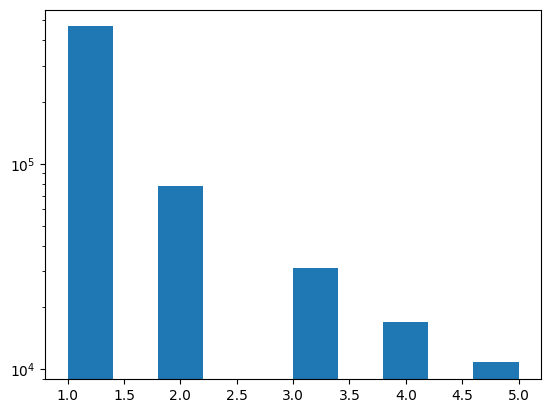

In [14]:
threshold = 5
plt.hist([e for e in tokenizer.word2count.values() if e <= threshold], density=False, log=True)
plt.show()

In [15]:
tokenizer.drop_words_below_thresh(threshold=threshold)

In [16]:
print(len(tokenizer.word2count_thresh) / len(tokenizer.word2count))
print(len(tokenizer.word2count_thresh))
print(len(tokenizer.word2count))

0.08402843357250651
55346
658658


In [48]:
tokenized_X = []

for line in X:
    token_line = [tokenizer.word2id[e] if e in tokenizer.word2id else tokenizer.word2id['<OUT>'] for e in line.split()]
    token_line.append(tokenizer.word2id['<EOS>'])
    tokenized_X.append(token_line)


In [49]:
print(*tokenized_X[:10], sep="\n")

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 1]
[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 31, 37, 38, 39, 40, 41, 1]
[42, 43, 44, 45, 46, 15, 47, 48, 49, 50, 1]
[51, 52, 53, 54, 55, 56, 57, 26, 58, 59, 60, 58, 26, 61, 62, 26, 8, 63, 64, 57, 65, 66, 1]
[67, 54, 31, 43, 68, 1]
[69, 19, 70, 1]
[71, 72, 73, 74, 52, 75, 76, 77, 19, 78, 79, 19, 78, 80, 26, 58, 81, 82, 83, 64, 1]
[26, 84, 85, 42, 86, 1]
[87, 26, 88, 89, 34, 90, 14, 15, 26, 91, 31, 92, 93, 94, 95, 1]
[96, 14, 14, 97, 98, 60, 26, 99, 100, 64, 101, 102, 34, 103, 104, 1]


In [50]:
assert (len(tokenized_X) == len(Y))

In [115]:
class Model(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()

        self.lstm_layer = nn.LSTM(input_size=input_size,
                                  hidden_size=hidden_size,
                                  num_layers=2,
                                  dropout=.2,
                                  bidirectional=False,
                                  batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 2)


    def forward(self, X):
        X, (h_n, c_n) = self.lstm_layer(X)
        X = X[:, -1, :]
        return self.fc(X)

